<a href="https://colab.research.google.com/github/GiornoFlavio/Superalgos/blob/master/YouTube_Quantreo_First_Trading_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2022/12/1.png" align="left" hspace="10px" vspace="0px"></p>


# HOW TO BUILD YOUR OWN TRADING BOT USING PYTHON ✅

</br>

The goal of this video is to show you how to build a basic trading bot using Python. We are going to develop a moving averages trading strategy to see if trade the trend is still profitable or not!
</br>
</br>
</br>

## Summary
##### - DATA PREPARATION
##### - CREATE TRADING SIGNALS
##### - COMPUTE THE PROFIT & LOSS (P&L)
##### - AUTOMATE THE PROCESS


</br>


📚Click there to obtain your E-book ➡️: https://quantreo.com



In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import datetime as dt
warnings.filterwarnings("ignore")

In [25]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

## DATA PREPARATION

We need to preprocess the data. The goal is to Standardize the data format at the beginning. Thus, if you use another data source, you just have to change this part and not the whole code.

In [28]:
def preprocessing_yf(symbol):

  #Import the data
  df = yf.download(symbol, start = dt.datetime ( 2023,1,1),end = dt.datetime.now(),interval = "1d").dropna()

  #Rename
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Remove adj close
  del df["adj close"]

  return df

df = preprocessing_yf("EURUSD=X")
df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2023-01-02,1.070973,1.071237,1.065326,1.070973,0
2023-01-03,1.067771,1.068262,1.052155,1.067771,0
2023-01-04,1.054685,1.063151,1.054596,1.054685,0
2023-01-05,1.060637,1.063264,1.051558,1.060637,0
2023-01-06,1.052222,1.062225,1.048526,1.052222,0
...,...,...,...,...,...
2023-10-17,1.055431,1.059500,1.053341,1.055431,0
2023-10-18,1.057306,1.059547,1.052709,1.057306,0
2023-10-19,1.053852,1.058537,1.052886,1.053852,0


# CREATE TRADING SIGNALS

Here, we need to define when we want to be in a buy position and when we want to be in a sell position.

<Axes: xlabel='time'>

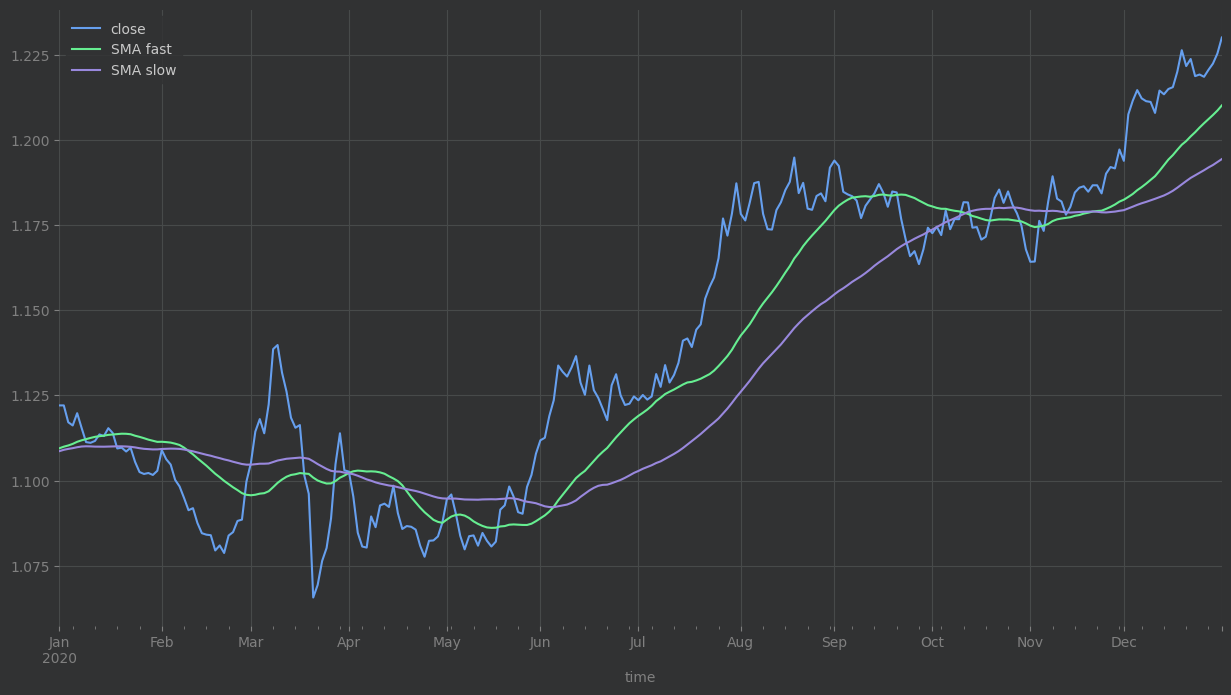

In [17]:
# Create Simple moving average 30 days
df["SMA fast"] = df["close"].rolling(30).mean()

# Create Simple moving average 60 days
df["SMA slow"] = df["close"].rolling(60).mean()

# Plot the results
df[["close", "SMA fast", "SMA slow"]].loc["2020"].plot(figsize=(15,8))

In [18]:
# Create an empty columns to put the signals
df["signal"]=np.nan

# Create the condition
condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))

df.loc[condition_buy, "signal"] = 1
df.loc[condition_sell, "signal"] = -1

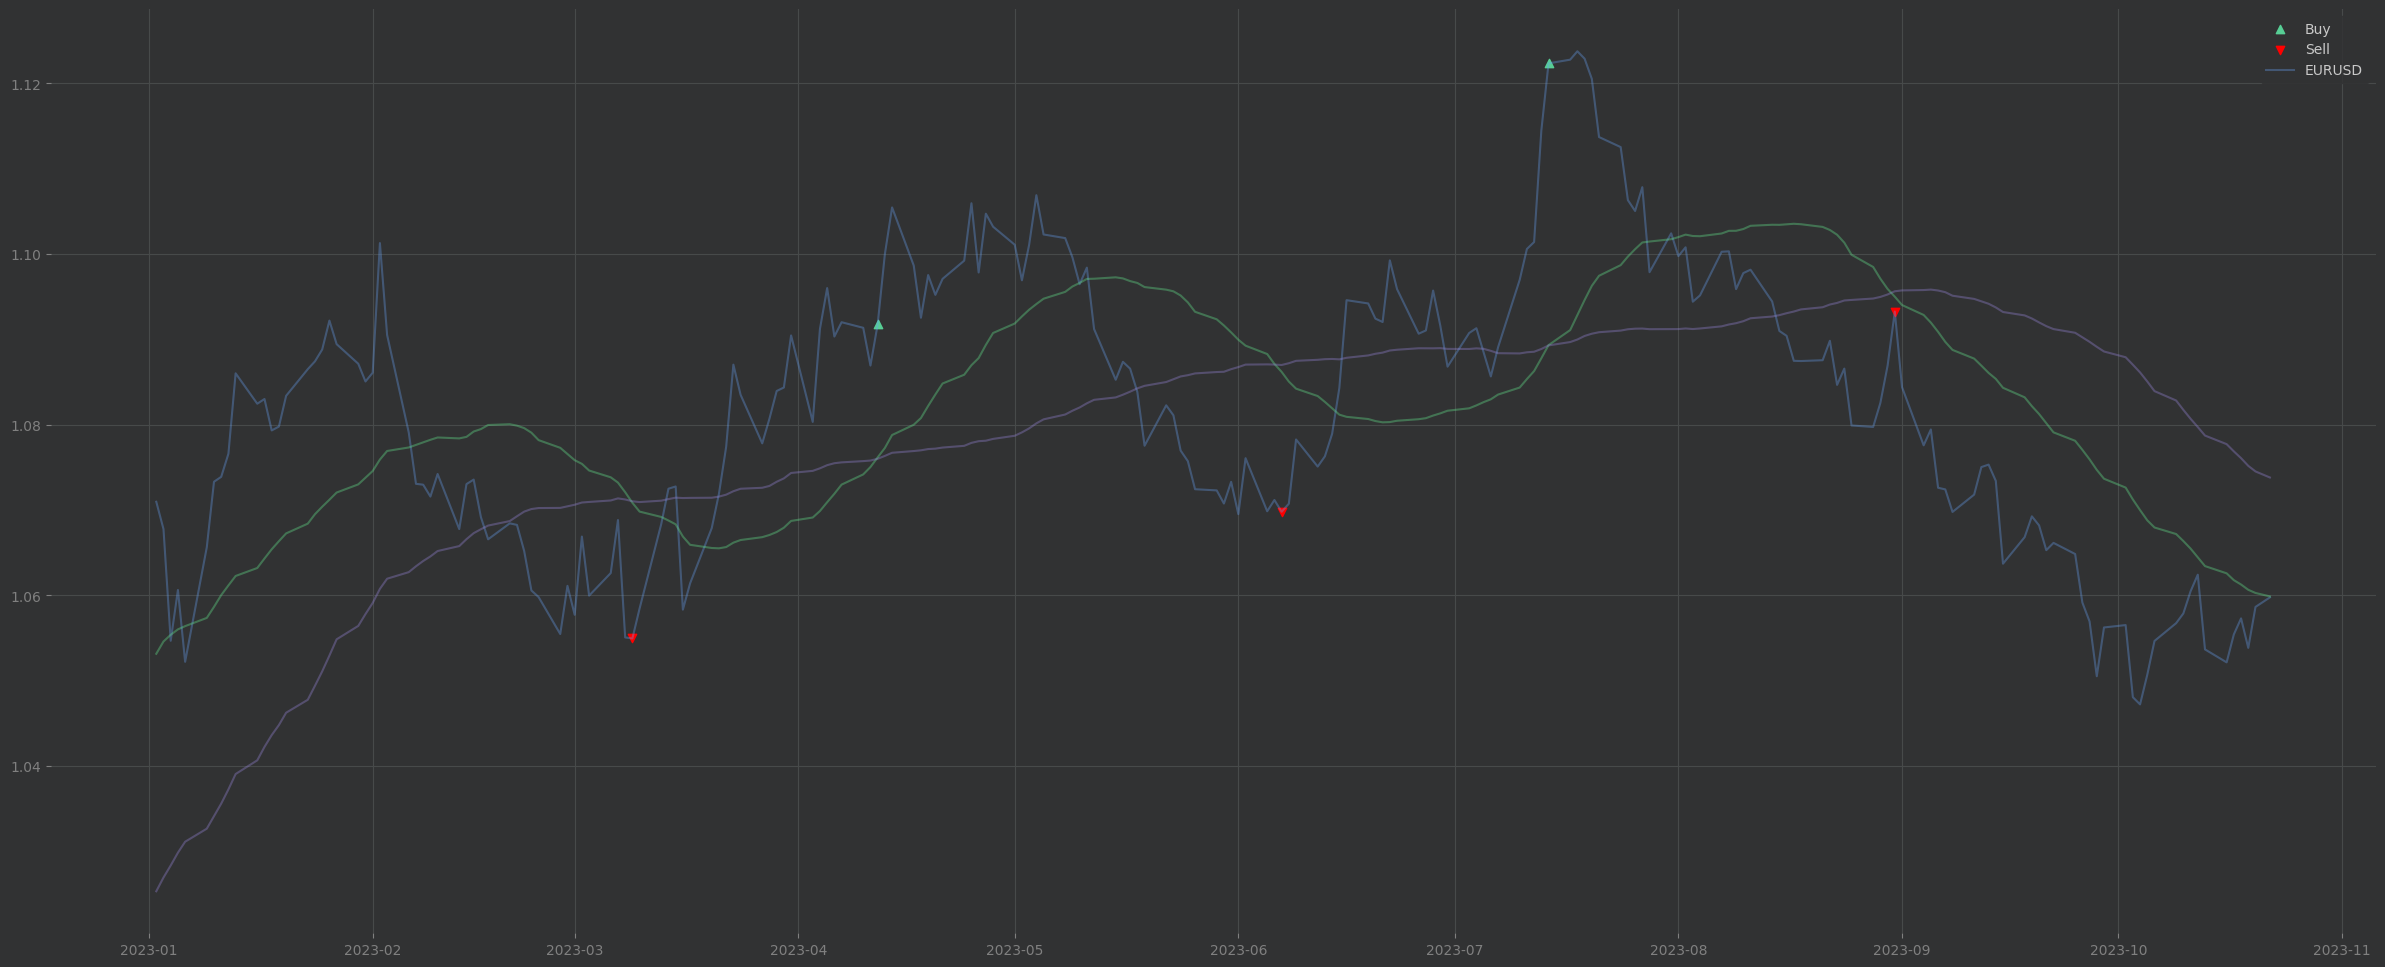

In [19]:
# We plot all the signla to be sure that they be correct

year="2023"

# Select all signal in a index list to plot only this points
idx_open = df.loc[df["signal"] == 1].loc[year].index
idx_close = df.loc[df["signal"] == -1].loc[year].index



# Adapt the size of the graph
plt.figure(figsize=(30,12))

# Plot the points of the open long signal in green and sell in red
plt.scatter(idx_open, df.loc[idx_open]["close"].loc[year], color= "#57CE95", marker="^")
plt.scatter(idx_close, df.loc[idx_close]["close"].loc[year], color= "red", marker="v")


# Plot the resistance to be sure that the conditions are completed
plt.plot(df["close"].loc[year].index, df["close"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA fast"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA slow"].loc[year], alpha=0.35)

plt.legend(["Buy", "Sell", "EURUSD"])

# Show the graph
plt.show()

## COMPUTE THE PROFIT & LOSS (P&L)
Once we have our trading signals, it is time to see if they are profitable or not.

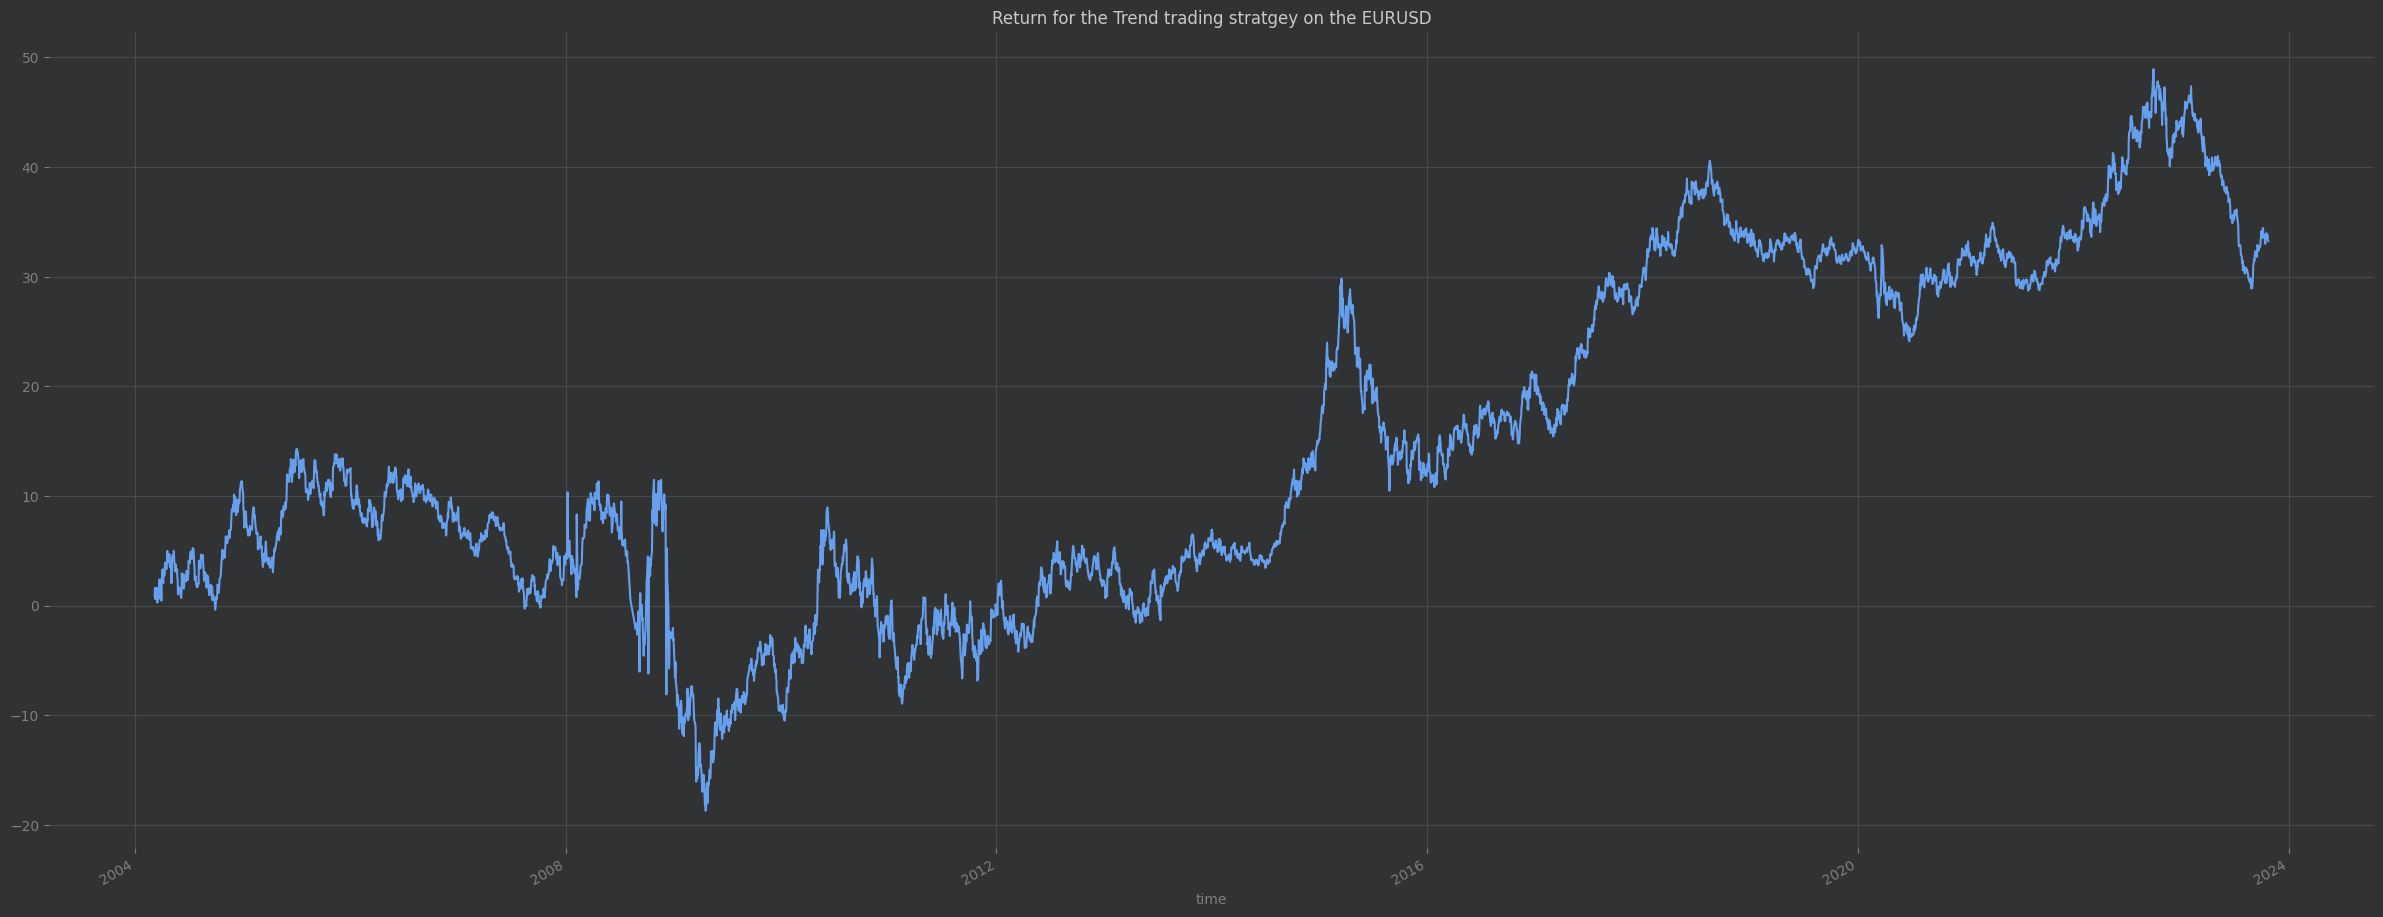

In [20]:
# We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
df["position"] = df["signal"].fillna(method="ffill")

# We define a fix cost we need to pay each time we interact with the market
cost_ind = 0.0001

# We create a vector of cost
df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0) #(-0.0001, 0, 0, 0, 0, 0 , 0, -0.0001, 0, 0) (-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,)

# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100


df["return"].cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey on the EURUSD")
plt.show()

## AUTOMATE THE PROCESS

Create a function to automate this process and be able to test this trading strategy on other assets in ONE CLICK!

In [21]:
def SMA_strategy(input, fast_sma=30, slow_sma=60, cost_ind=0.0001):

  df = preprocessing_yf(input)


  # Create Resistance using a rolling max
  df["SMA fast"] = df["close"].rolling(fast_sma).mean()

  # Create Support using a rolling min
  df["SMA slow"] = df["close"].rolling(slow_sma).mean()

  # Create an empty columns to put the signals
  df["signal"]=np.nan

  # Create the condition
  condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
  condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))

  df.loc[condition_buy, "signal"] = 1
  df.loc[condition_sell, "signal"] = -1

  # We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
  df["position"] = df["signal"].fillna(method="ffill")

  # We create a vector of cost
  df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy
  df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100


  return df["return"]

[*********************100%%**********************]  1 of 1 completed


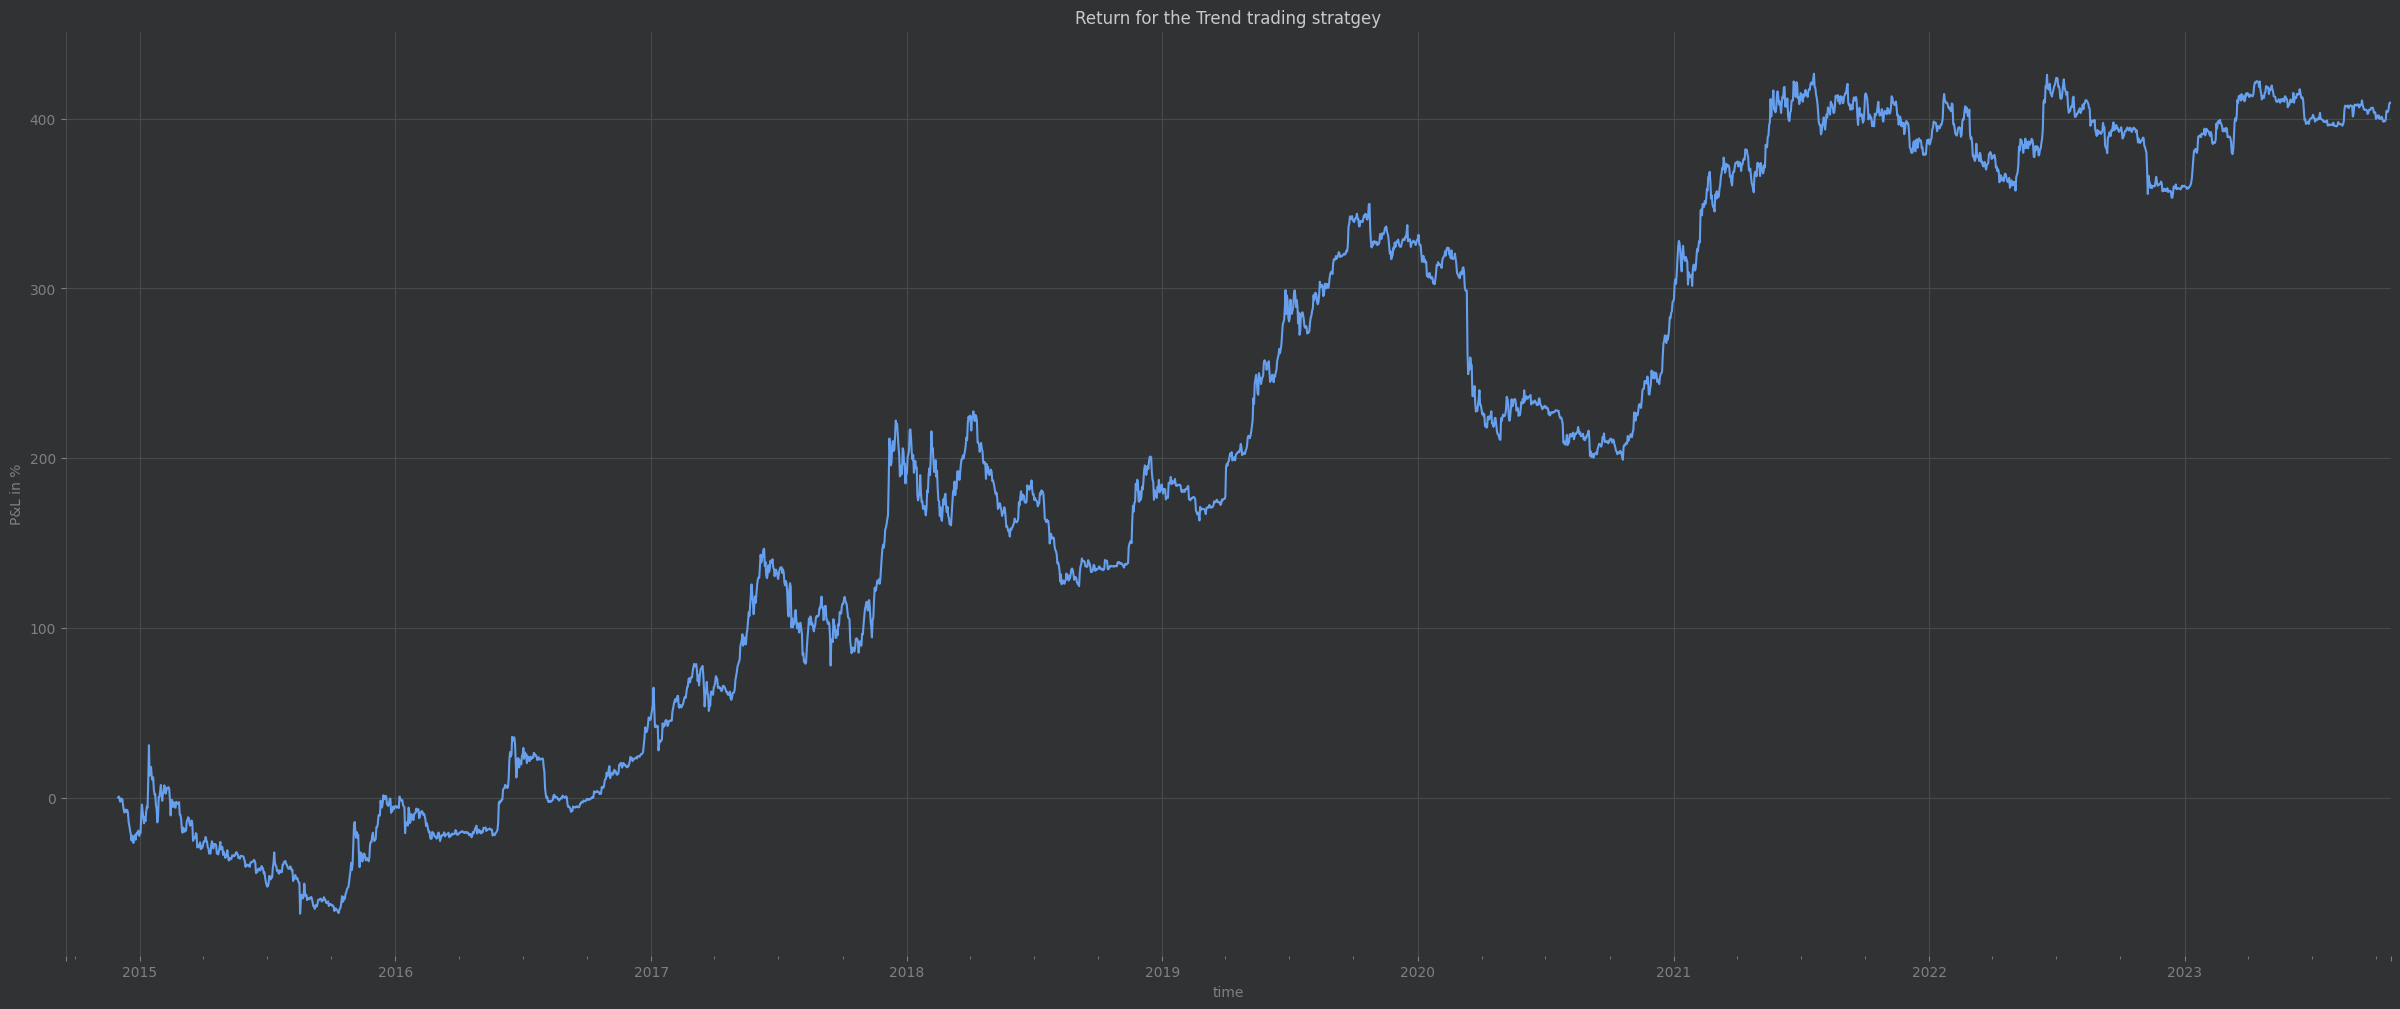

In [22]:
SMA_strategy("BTC-USD", 30,60,0.001).cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey", ylabel="P&L in %")
plt.show()

[*********************100%%**********************]  1 of 1 completed


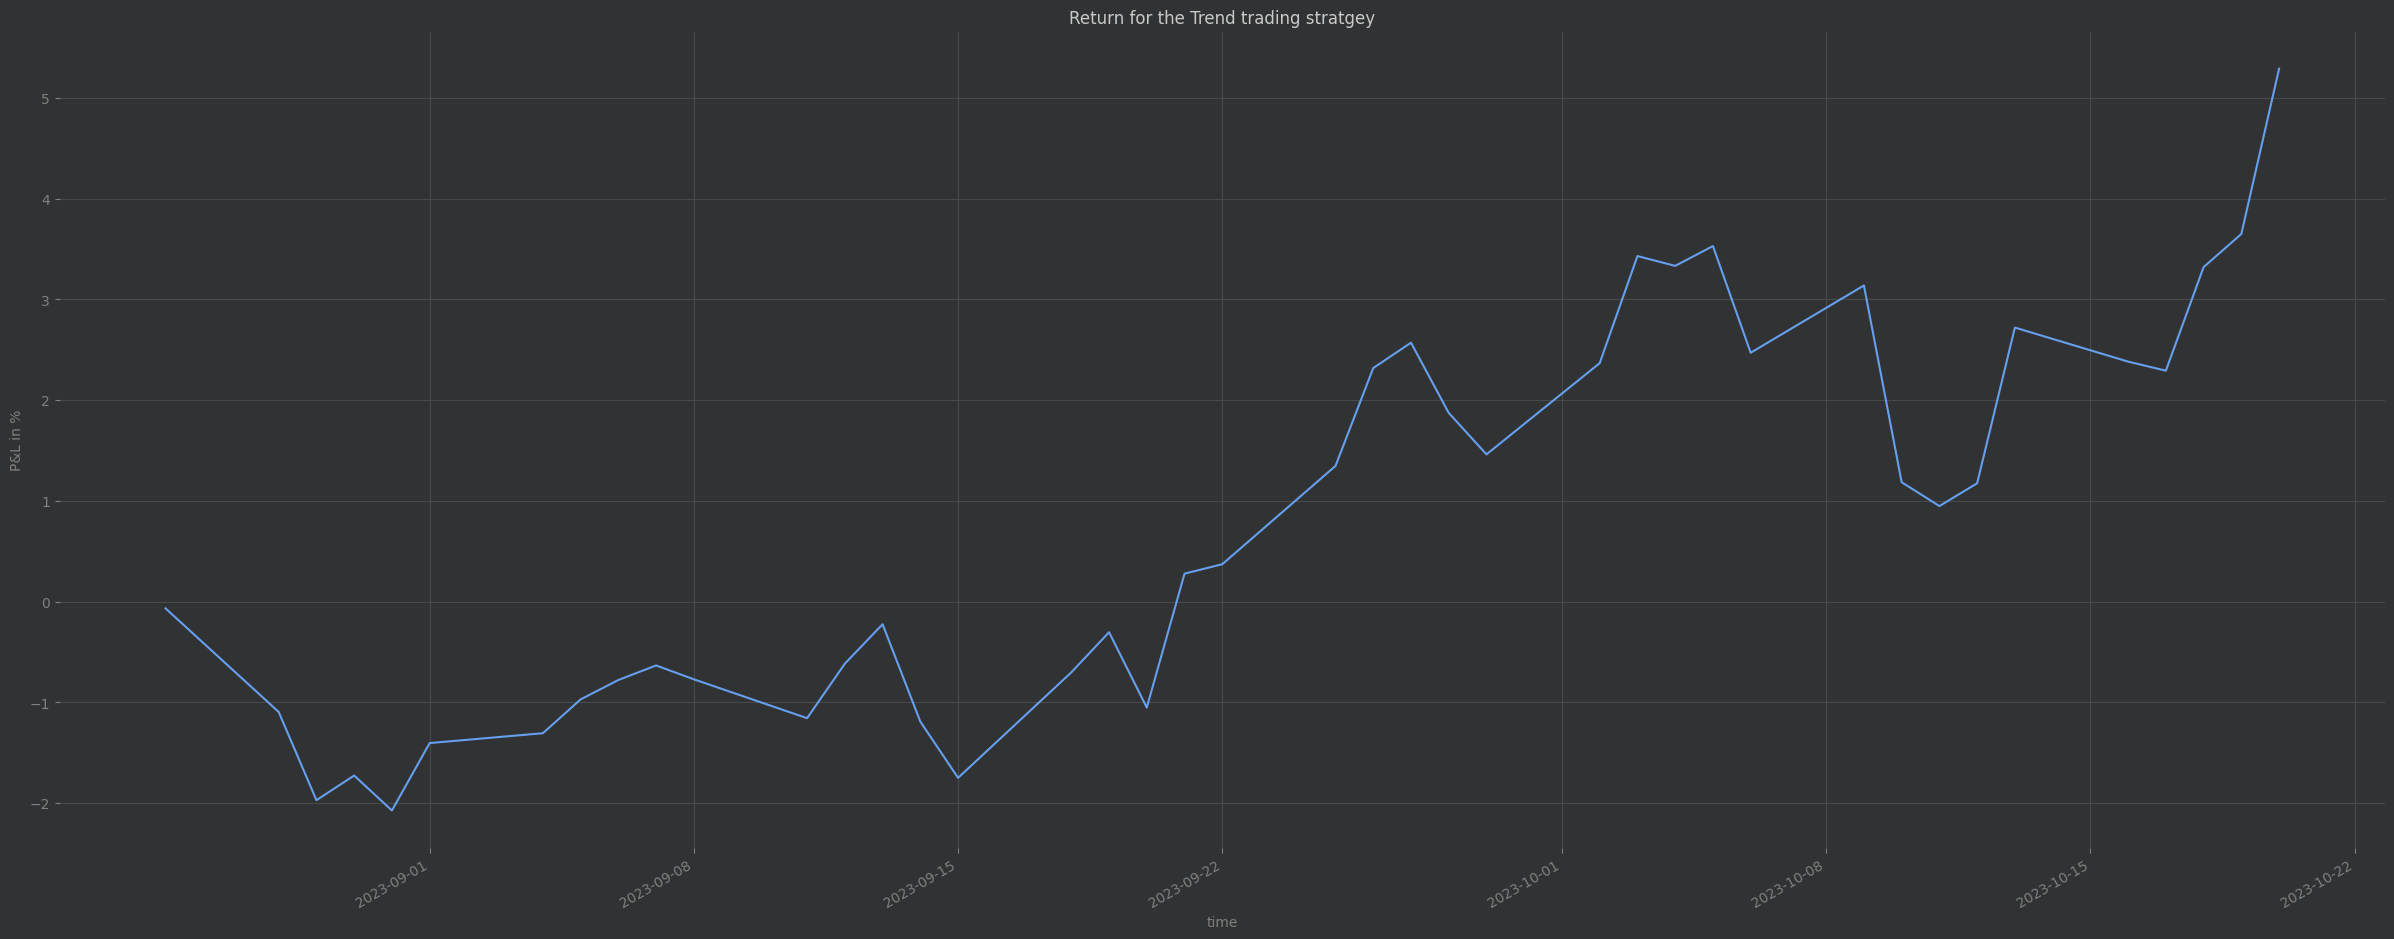

In [29]:
SMA_strategy("^GDAXI", 30,60,0.001).cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey", ylabel="P&L in %")
plt.show()

[*********************100%%**********************]  1 of 1 completed


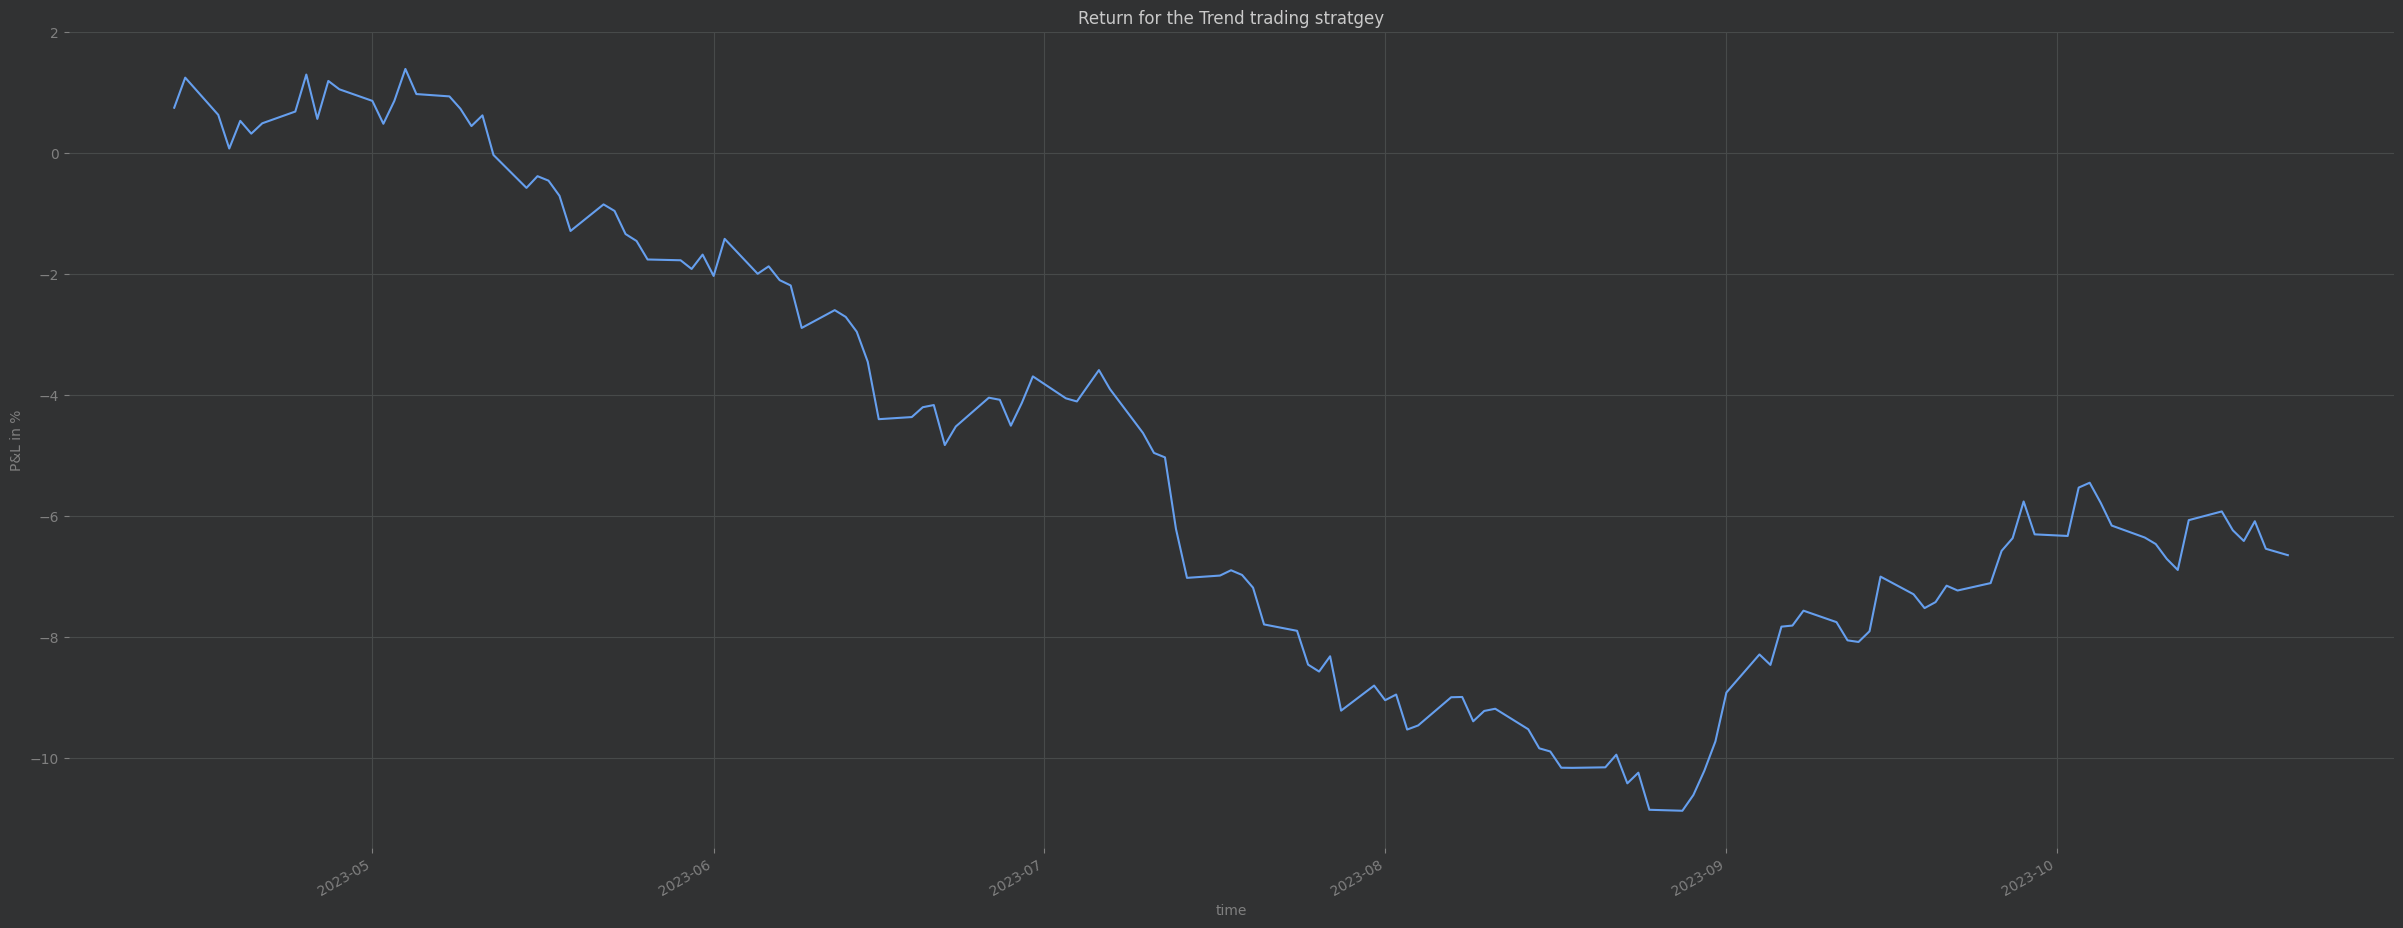

In [30]:
SMA_strategy("EURUSD=X", 30,60,0.001).cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey", ylabel="P&L in %")
plt.show()